In [1]:
import pandas as pd
import numpy as np
import random as rand

import sqlite3

import torch
from torch import nn
from torch.nn import Dropout
from torch.utils.data import Dataset, DataLoader

import torchtuples as tt

#from pycox.models import CoxPH
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import utils

seed_value = 123456
torch.manual_seed(seed_value)

## Import DataLoader

In [2]:
features = ['CREDIT_SCORE', 'ORIG_DTI_RATIO', 'ORIG_UPB', 'ORIG_LTV', 'ORIG_INTEREST_RATE', 'UPB_Share',
           'TIMES_NOT_BEING_DELINQUENT','TIMES_BEING_DELINQUENT_30_DAYS','TIMES_BEING_DELINQUENT_60_DAYS']

## SETUP VARS
event_var = 'DEFAULT'
dep_var = 'REMAINING_SURVIVAL_TIME'

data = pd.read_csv('data/loans_labelled_train.csv')

#subsample_n = 1000
#data = data.sample(subsample_n)

# sample validation data
train_ids = data.LOAN_SEQ_NUMBER.sample(int(0.8 * len(data)), random_state=seed_value)

data_val = data[~data.LOAN_SEQ_NUMBER.isin(train_ids)].copy()
data = data[data.LOAN_SEQ_NUMBER.isin(train_ids)]

data = data[features + [event_var, dep_var]]
data_val = data_val[features + [event_var, dep_var]]

X_train, y_train, e_train, features = utils.get_features_and_outcomes(data, event_var, dep_var)
X_val, y_val, e_val, _ = utils.get_features_and_outcomes(data_val, event_var, dep_var)

###
data_test = pd.read_csv('data/loans_labelled_test.csv')
data_test = data_test[features + [event_var, dep_var]]

X_test, y_test, e_test, features = utils.get_features_and_outcomes(data_test, event_var, dep_var)


In [3]:
# scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)


num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
#get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(y_train, e_train)
y_val = labtrans.transform(y_val, e_val)
#y_test = labtrans.transform(y_test, e_test)

val_data = (X_val, y_val)
print("X_train " + str(X_train.shape))
print("X_test " + str(X_test.shape))

X_train (199223, 9)
X_test (40761, 9)


In [4]:
y_test = (
    np.array(y_test).astype(np.float32).flatten(),
    np.array(e_test).astype(np.float32).flatten())

## Train Model
### DeepHit

In [5]:
# Surv. Model Architecture
class FeedforwardNN(nn.Module):
    
    def __init__(self, input_size, out_size, num_nodes, num_layers, dropout_rate=0.5):
        super(FeedforwardNN, self).__init__()
       
        self.first_layer = nn.Sequential(nn.Linear(input_size, num_nodes),
                                            nn.ReLU(),
                                            nn.Dropout(p = dropout_rate))
        
        self.hidden_layer = nn.Sequential(nn.Linear(num_nodes, num_nodes),
                                            nn.ReLU(),
                                            nn.Dropout(p = dropout_rate))
        
        self.hidden = nn.ModuleList([self.hidden_layer for i in range(num_layers - 1)])
            
        self.final_layer = nn.Linear(in_features=num_nodes, out_features=out_size)
        
    def forward(self, X):
        
        z = self.first_layer(X)
        
        # Propogate through Hidden Layers
        for hidden_layer in self.hidden:
            z = hidden_layer(z)
        
        # Output Layer
        out = self.final_layer(z)
        
        return out

## Hyperparameter Tuning

In [6]:
# draw some random hyperparameter from the range
def draw_hyperparameters(param):
    return search_space[param][rand.randint(0,len(search_space[param]) - 1)]

def get_optim(name):
    if name == 'Adam':
        return tt.optim.Adam
    
    ## currently not working...
    #if name == 'AdamWR':
    #    return tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
    #                        cycle_multiplier=2)
    
    return tt.optim.SGD


In [8]:
## Model Parameter
in_features = X_train.shape[1]
out_features = labtrans.out_features

max_epochs = 60

# number of parameter which should be evaluated
n_search = 50

search_space = {
    'layers' : [2, 4, 6],
    'nodes' : [6, 9, 24, 50, 100, 200],
    'alpha' : [0.1, 0.2, 0.5, 1],
    'sigma' : [0.1, 0.2, 0.5, 1],
    'optim': ['Adam'], # ,  'SGD'
    'dropout_rate' : [0.5, 0.7],
    'lr' : [0.01, 0.001],
    'batch_size': [254, 1024, 4096, 16384]
}

In [9]:
# draw random number for each feature and save as sequence
# continue drawing as long as no unique combination found

hyperparamter_results_df = None

#set of already evaluated hyperparemeters
evaluate_params = set()

iteration = 0
while(iteration < n_search):
    
    ## Draw the hyperparameter
    layers = draw_hyperparameters('layers')
    nodes = draw_hyperparameters('nodes')
    alpha = draw_hyperparameters('alpha')
    sigma = draw_hyperparameters('sigma')
    optim_name = draw_hyperparameters('optim')
    optim = get_optim(optim_name)
    dropout_rate = draw_hyperparameters('dropout_rate')
    lr = draw_hyperparameters('lr')
    batch_size = draw_hyperparameters('batch_size')
    
    ## use String representation of features to remember that they were already evaluated
    params_str = str(layers) + str(nodes) + str(optim) + str(dropout_rate) + str(lr) + str(batch_size)
    
    # in case already evaluted draw new hyperparamter
    if params_str in evaluate_params:
        continue
    
    if iteration % 2 == 0:
        print("Iteration: " + str(iteration))

    net = FeedforwardNN(input_size=in_features, out_size=out_features, num_nodes=nodes, 
                        num_layers=layers, dropout_rate=dropout_rate)

    callbacks = [tt.callbacks.EarlyStopping()]
    
    
    deep_hit = DeepHitSingle(net, optim, alpha=alpha, sigma=sigma, duration_index=labtrans.cuts)
    deep_hit.optimizer.set_lr(lr)

    # Fit the model
    log = deep_hit.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, verbose=0,
                                callbacks=callbacks, val_data=val_data)
    
    surv = deep_hit.interpolate(10).predict_surv_df(X_val)
    
    # Concordance index
    ev = EvalSurv(surv, y_val[0], y_val[1], censor_surv='km')
    c_index = ev.concordance_td()                    
    min_val_loss = log.to_pandas().val_loss.min()
    min_train_loss = log.to_pandas().train_loss.min()
    # save both for best loss and for best c_index
    
    # append results
    append_row = pd.DataFrame({
        'Iteration' : [iteration],
        'Epochs' : [log.epochs[-1]],
        'Layers' : [layers],
        'Nodes' : [nodes],
        'Sigma' : [sigma],
        'Alpha' : [alpha],
        'Optimizer' : [optim_name],
        'Dropout' : [dropout_rate],
        'LR' : [lr],
        'Batch_Size' : [batch_size],
        'Train_Loss' : [min_train_loss],
        'Val_Loss' : [min_val_loss],
        'C_Index' : [c_index]
    })
    
    if hyperparamter_results_df is None:
        hyperparamter_results_df = append_row.copy()
    else:
        hyperparamter_results_df = hyperparamter_results_df.append(append_row)
    
    iteration = iteration + 1

Iteration: 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Iteration: 2
Iteration: 4
Iteration: 6
Iteration: 8
Iteration: 10
Iteration: 12
Iteration: 14
Iteration: 16
Iteration: 18
Iteration: 20
Iteration: 22
Iteration: 24
Iteration: 26
Iteration: 28
Iteration: 30
Iteration: 32
Iteration: 34
Iteration: 36
Iteration: 38
Iteration: 40
Iteration: 42
Iteration: 44
Iteration: 46
Iteration: 48


In [10]:
hyperparamter_results_df.sort_values('C_Index', ascending=False).head(40)

,Iteration,Epochs,Layers,Nodes,Sigma,Alpha,Optimizer,Dropout,LR,Batch_Size,Train_Loss,Val_Loss,C_Index
0,22,29,6,200,0.1,0.1,Adam,0.5,0.010,16384,0.011384,0.011969,0.876845
0,25,16,2,100,0.5,0.2,Adam,0.5,0.010,4096,0.018674,0.019496,0.876809
0,16,12,4,200,0.5,0.5,Adam,0.7,0.001,254,0.039828,0.039958,0.875448
0,32,44,4,100,0.2,0.2,Adam,0.5,0.010,16384,0.017950,0.019018,0.875442
0,24,32,4,24,1.0,1.0,Adam,0.5,0.010,1024,0.073800,0.074648,0.875369
0,4,55,2,100,0.1,0.2,Adam,0.5,0.001,4096,0.017687,0.018894,0.875296
0,8,49,6,100,1.0,0.2,Adam,0.7,0.001,1024,0.019791,0.019945,0.875164
0,47,35,2,50,1.0,0.2,Adam,0.7,0.001,254,0.019516,0.019915,0.875149
0,37,51,2,9,0.1,0.5,Adam,0.7,0.001,254,0.041690,0.041034,0.875101
0,2,21,6,200,0.1,0.1,Adam,0.7,0.010,16384,0.012552,0.012776,0.875065


In [11]:
hyperparamter_results_df.to_csv('search_deephit.csv', index=False)

In [8]:
hyperparamter_results_df = pd.read_csv('search_deephit.csv')

## Train final model on best Hyperparameters

In [12]:
best_hyperparam = hyperparamter_results_df.sort_values('C_Index', ascending=False).iloc[0]

best_layers = best_hyperparam['Layers']
best_nodes = best_hyperparam['Nodes']
best_sigma = best_hyperparam['Sigma']
best_alpha = best_hyperparam['Alpha']
best_optim = get_optim(best_hyperparam['Optimizer'])
best_lr = best_hyperparam['LR']
best_dropout = best_hyperparam['Dropout']
best_batch_size = best_hyperparam['Batch_Size']


In [13]:
net = FeedforwardNN(input_size=in_features, out_size=out_features, num_nodes=best_nodes , num_layers=int(best_layers), dropout_rate=best_dropout)

deep_hit = DeepHitSingle(net, best_optim, alpha=best_alpha, sigma=best_sigma, duration_index=labtrans.cuts)

In [14]:
callbacks = [tt.callbacks.EarlyStopping()]

log = deep_hit.fit(X_train, y_train, int(best_batch_size), epochs=100, val_data=val_data, callbacks=callbacks)


0:	[7s / 7s],		train_loss: 0.0581,	val_loss: 0.0268
1:	[7s / 15s],		train_loss: 0.0294,	val_loss: 0.0226
2:	[7s / 23s],		train_loss: 0.0217,	val_loss: 0.0182
3:	[7s / 31s],		train_loss: 0.0184,	val_loss: 0.0166
4:	[7s / 39s],		train_loss: 0.0169,	val_loss: 0.0153
5:	[7s / 47s],		train_loss: 0.0153,	val_loss: 0.0135
6:	[7s / 55s],		train_loss: 0.0135,	val_loss: 0.0134
7:	[7s / 1m:3s],		train_loss: 0.0133,	val_loss: 0.0131
8:	[7s / 1m:11s],		train_loss: 0.0130,	val_loss: 0.0130
9:	[7s / 1m:19s],		train_loss: 0.0129,	val_loss: 0.0131
10:	[7s / 1m:27s],		train_loss: 0.0127,	val_loss: 0.0129
11:	[7s / 1m:35s],		train_loss: 0.0125,	val_loss: 0.0129
12:	[7s / 1m:43s],		train_loss: 0.0125,	val_loss: 0.0127
13:	[7s / 1m:51s],		train_loss: 0.0126,	val_loss: 0.0127
14:	[7s / 1m:59s],		train_loss: 0.0124,	val_loss: 0.0127
15:	[7s / 2m:7s],		train_loss: 0.0124,	val_loss: 0.0126
16:	[7s / 2m:15s],		train_loss: 0.0123,	val_loss: 0.0125
17:	[8s / 2m:23s],		train_loss: 0.0122,	val_loss: 0.0124
18:	[8s 

<AxesSubplot:>

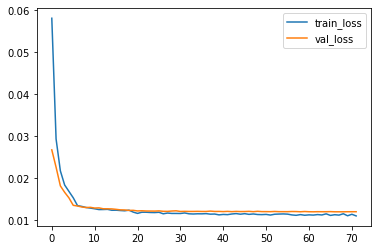

In [15]:
log.plot()

## Test Data C-Index

In [16]:
test_c_index = utils.get_c_index(deep_hit, X_test, y_test, is_deep_hit=True)
test_c_index

0.8072640920172575

## Explore Feature Importance 

### Permutation Importance

In [17]:
permutation_feature_results = utils.get_permutation_results(deep_hit, X_test, y_test, n_repeats = 10, is_deep_hit = True)
orig_c_index = utils.get_c_index(deep_hit, X_test, y_test, is_deep_hit = True)

In [18]:
perc_decrease = ((np.array(permutation_feature_results) / orig_c_index) - 1) * 100

# percentage decrese of C-Index
permuattion_importance = pd.DataFrame({
        'Feature': features,
        'Delta_C_Index': perc_decrease
    })

<AxesSubplot:ylabel='Feature'>

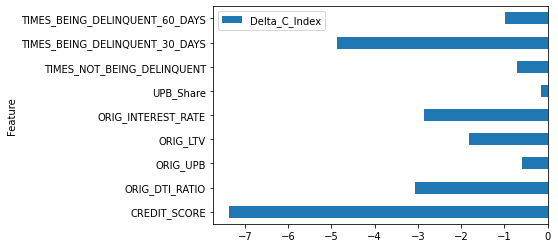

In [ ]:
permuattion_importance.set_index('Feature').plot(kind='barh')

# does this mean overfitting ??

In [ ]:
permuattion_importance.to_csv('./deep_hit_permutation_importance.csv', index=False)
permuattion_importance

,Feature,Delta_C_Index
0,CREDIT_SCORE,-7.370921
1,ORIG_DTI_RATIO,-3.067559
2,ORIG_UPB,-0.600024
3,ORIG_LTV,-1.819527
4,ORIG_INTEREST_RATE,-2.863366
5,UPB_Share,-0.163687
6,TIMES_NOT_BEING_DELINQUENT,-0.710796
7,TIMES_BEING_DELINQUENT_30_DAYS,-4.883212
8,TIMES_BEING_DELINQUENT_60_DAYS,-0.983851


### Export final results

In [ ]:
deep_hit_full_predictions = utils.get_stochastic_surv_func(deep_hit, X_test, n = 100, model_name='DeepHit_MC', interpolate=10)
deep_hit_full_predictions

,ID,PERIOD,MODEL,PRED_80_LOW,PRED_80_HIGH,PRED_95_LOW,PRED_95_HIGH,PRED_MEAN
0,1,1,DeepHit_MC,0.999999,1.000000,0.999992,1.000000,0.999999
1,1,2,DeepHit_MC,0.999994,1.000000,0.999958,1.000000,0.999996
2,1,3,DeepHit_MC,0.999989,1.000000,0.999924,1.000000,0.999993
3,1,4,DeepHit_MC,0.999984,1.000000,0.999890,1.000000,0.999990
4,1,5,DeepHit_MC,0.999979,1.000000,0.999856,1.000000,0.999987
...,...,...,...,...,...,...,...,...
1997284,40761,45,DeepHit_MC,0.951079,0.997064,0.916287,0.999013,0.978570
1997285,40761,46,DeepHit_MC,0.947397,0.996647,0.905015,0.998916,0.976148
1997286,40761,47,DeepHit_MC,0.942666,0.996210,0.896235,0.998803,0.973724
1997287,40761,48,DeepHit_MC,0.937595,0.995939,0.887455,0.998719,0.971908


In [ ]:
db_path = './predictions/test_evaluation.sqlite'
con = sqlite3.connect(db_path)

deep_hit_full_predictions.to_sql('TB02_PREDICTIONS', con, index=False, if_exists='append')

con.close()